<a href="https://colab.research.google.com/github/ARYANSRIVATSAVA/Projects/blob/main/Eye_tracking_improvised_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2


class Pupil(object):
    """
    This class detects the iris of an eye and estimates
    the position of the pupil
    """

    def __init__(self, eye_frame, threshold):
        self.iris_frame = None
        self.threshold = threshold
        self.x = None
        self.y = None

        self.detect_iris(eye_frame)

    @staticmethod
    def image_processing(eye_frame, threshold):
        """Performs operations on the eye frame to isolate the iris

        Arguments:
            eye_frame (numpy.ndarray): Frame containing an eye and nothing else
            threshold (int): Threshold value used to binarize the eye frame

        Returns:
            A frame with a single element representing the iris
        """
        kernel = np.ones((3, 3), np.uint8)
        new_frame = cv2.bilateralFilter(eye_frame, 10, 15, 15)
        new_frame = cv2.erode(new_frame, kernel, iterations=3)
        new_frame = cv2.threshold(new_frame, threshold, 255, cv2.THRESH_BINARY)[1]

        return new_frame

    def detect_iris(self, eye_frame):
        """Detects the iris and estimates the position of the iris by
        calculating the centroid.

        Arguments:
            eye_frame (numpy.ndarray): Frame containing an eye and nothing else
        """
        self.iris_frame = self.image_processing(eye_frame, self.threshold)

        contours, _ = cv2.findContours(self.iris_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
        contours = sorted(contours, key=cv2.contourArea)

        try:
            moments = cv2.moments(contours[-2])
            self.x = int(moments['m10'] / moments['m00'])
            self.y = int(moments['m01'] / moments['m00'])
        except (IndexError, ZeroDivisionError):
            pass


In [ ]:
import math
#from .pupil import Pupil


class Eye(object):
    """
    This class creates a new frame to isolate the eye and
    initiates the pupil detection.
    """

    LEFT_EYE_POINTS = [36, 37, 38, 39, 40, 41]
    RIGHT_EYE_POINTS = [42, 43, 44, 45, 46, 47]

    def __init__(self, original_frame, landmarks, side, calibration):
        self.frame = None
        self.origin = None
        self.center = None
        self.pupil = None

        self._analyze(original_frame, landmarks, side, calibration)

    @staticmethod
    def _middle_point(p1, p2):
        """Returns the middle point (x,y) between two points

        Arguments:
            p1 (dlib.point): First point
            p2 (dlib.point): Second point
        """
        x = int((p1.x + p2.x) / 2)
        y = int((p1.y + p2.y) / 2)
        return (x, y)

    def _isolate(self, frame, landmarks, points):
        """Isolate an eye, to have a frame without other part of the face.

        Arguments:
            frame (numpy.ndarray): Frame containing the face
            landmarks (dlib.full_object_detection): Facial landmarks for the face region
            points (list): Points of an eye (from the 68 Multi-PIE landmarks)
        """
        region = np.array([(landmarks.part(point).x, landmarks.part(point).y) for point in points])
        region = region.astype(np.int32)

        # Applying a mask to get only the eye
        height, width = frame.shape[:2]
        black_frame = np.zeros((height, width), np.uint8)
        mask = np.full((height, width), 255, np.uint8)
        cv2.fillPoly(mask, [region], (0, 0, 0))
        eye = cv2.bitwise_not(black_frame, frame.copy(), mask=mask)

        # Cropping on the eye
        margin = 5
        min_x = np.min(region[:, 0]) - margin
        max_x = np.max(region[:, 0]) + margin
        min_y = np.min(region[:, 1]) - margin
        max_y = np.max(region[:, 1]) + margin

        self.frame = eye[min_y:max_y, min_x:max_x]
        self.origin = (min_x, min_y)

        height, width = self.frame.shape[:2]
        self.center = (width / 2, height / 2)

    def _blinking_ratio(self, landmarks, points):
        """Calculates a ratio that can indicate whether an eye is closed or not.
        It's the division of the width of the eye, by its height.

        Arguments:
            landmarks (dlib.full_object_detection): Facial landmarks for the face region
            points (list): Points of an eye (from the 68 Multi-PIE landmarks)

        Returns:
            The computed ratio
        """
        left = (landmarks.part(points[0]).x, landmarks.part(points[0]).y)
        right = (landmarks.part(points[3]).x, landmarks.part(points[3]).y)
        top = self._middle_point(landmarks.part(points[1]), landmarks.part(points[2]))
        bottom = self._middle_point(landmarks.part(points[5]), landmarks.part(points[4]))

        eye_width = math.hypot((left[0] - right[0]), (left[1] - right[1]))
        eye_height = math.hypot((top[0] - bottom[0]), (top[1] - bottom[1]))

        try:
            ratio = eye_width / eye_height
        except ZeroDivisionError:
            ratio = None

        return ratio

    def _analyze(self, original_frame, landmarks, side, calibration):
        """Detects and isolates the eye in a new frame, sends data to the calibration
        and initializes Pupil object.

        Arguments:
            original_frame (numpy.ndarray): Frame passed by the user
            landmarks (dlib.full_object_detection): Facial landmarks for the face region
            side: Indicates whether it's the left eye (0) or the right eye (1)
            calibration (calibration.Calibration): Manages the binarization threshold value
        """
        if side == 0:
            points = self.LEFT_EYE_POINTS
        elif side == 1:
            points = self.RIGHT_EYE_POINTS
        else:
            return

        self.blinking = self._blinking_ratio(landmarks, points)
        self._isolate(original_frame, landmarks, points)

        if not calibration.is_complete():
            calibration.evaluate(self.frame, side)

        threshold = calibration.threshold(side)
        self.pupil = Pupil(self.frame, threshold)

# New section

In [ ]:
from __future__ import division
import cv2
#from .pupil import Pupil


class Calibration(object):
    """
    This class calibrates the pupil detection algorithm by finding the
    best binarization threshold value for the person and the webcam.
    """

    def __init__(self):
        self.nb_frames = 20
        self.thresholds_left = []
        self.thresholds_right = []

    def is_complete(self):
        """Returns true if the calibration is completed"""
        return len(self.thresholds_left) >= self.nb_frames and len(self.thresholds_right) >= self.nb_frames

    def threshold(self, side):
        """Returns the threshold value for the given eye.

        Argument:
            side: Indicates whether it's the left eye (0) or the right eye (1)
        """
        if side == 0:
            return int(sum(self.thresholds_left) / len(self.thresholds_left))
        elif side == 1:
            return int(sum(self.thresholds_right) / len(self.thresholds_right))

    @staticmethod
    def iris_size(frame):
        """Returns the percentage of space that the iris takes up on
        the surface of the eye.

        Argument:
            frame (numpy.ndarray): Binarized iris frame
        """
        frame = frame[5:-5, 5:-5]
        height, width = frame.shape[:2]
        nb_pixels = height * width
        nb_blacks = nb_pixels - cv2.countNonZero(frame)
        return nb_blacks / nb_pixels

    @staticmethod
    def find_best_threshold(eye_frame):
        """Calculates the optimal threshold to binarize the
        frame for the given eye.

        Argument:
            eye_frame (numpy.ndarray): Frame of the eye to be analyzed
        """
        average_iris_size = 0.48
        trials = {}

        for threshold in range(5, 100, 5):
            iris_frame = Pupil.image_processing(eye_frame, threshold)
            trials[threshold] = Calibration.iris_size(iris_frame)

        best_threshold, iris_size = min(trials.items(), key=(lambda p: abs(p[1] - average_iris_size)))
        return best_threshold

    def evaluate(self, eye_frame, side):
        """Improves calibration by taking into consideration the
        given image.

        Arguments:
            eye_frame (numpy.ndarray): Frame of the eye
            side: Indicates whether it's the left eye (0) or the right eye (1)
        """
        threshold = self.find_best_threshold(eye_frame)

        if side == 0:
            self.thresholds_left.append(threshold)
        elif side == 1:
            self.thresholds_right.append(threshold)

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from __future__ import division
import os
import cv2
import dlib
#from .eye import Eye
#from .calibration import Calibration


class GazeTracking(object):
    """
    This class tracks the user's gaze.
    It provides useful information like the position of the eyes
    and pupils and allows to know if the eyes are open or closed
    """

    def __init__(self):
        self.frame = None
        self.eye_left = None
        self.eye_right = None
        self.calibration = Calibration()

        # _face_detector is used to detect faces
        self._face_detector = dlib.get_frontal_face_detector()

        # _predictor is used to get facial landmarks of a given face
        # cwd = os.path.abspath(os.path.dirname(__file__))
        # model_path = os.path.abspath(os.path.join(cwd, "trained_models/shape_predictor_68_face_landmarks.dat"))
        self._predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    @property
    def pupils_located(self):
        """Check that the pupils have been located"""
        try:
            int(self.eye_left.pupil.x)
            int(self.eye_left.pupil.y)
            int(self.eye_right.pupil.x)
            int(self.eye_right.pupil.y)
            return True
        except Exception:
            return False

    def _analyze(self):
        """Detects the face and initialize Eye objects"""
        frame = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
        faces = self._face_detector(frame)

        try:
            landmarks = self._predictor(frame, faces[0])
            self.eye_left = Eye(frame, landmarks, 0, self.calibration)
            self.eye_right = Eye(frame, landmarks, 1, self.calibration)

        except IndexError:
            self.eye_left = None
            self.eye_right = None

    def refresh(self, frame):
        """Refreshes the frame and analyzes it.

        Arguments:
            frame (numpy.ndarray): The frame to analyze
        """
        self.frame = frame
        self._analyze()

    def pupil_left_coords(self):
        """Returns the coordinates of the left pupil"""
        if self.pupils_located:
            x = self.eye_left.origin[0] + self.eye_left.pupil.x
            y = self.eye_left.origin[1] + self.eye_left.pupil.y
            return (x, y)

    def pupil_right_coords(self):
        """Returns the coordinates of the right pupil"""
        if self.pupils_located:
            x = self.eye_right.origin[0] + self.eye_right.pupil.x
            y = self.eye_right.origin[1] + self.eye_right.pupil.y
            return (x, y)

    def horizontal_ratio(self):
        """Returns a number between 0.0 and 1.0 that indicates the
        horizontal direction of the gaze. The extreme right is 0.0,
        the center is 0.5 and the extreme left is 1.0
        """
        if self.pupils_located:
            pupil_left = self.eye_left.pupil.x / (self.eye_left.center[0] * 2 - 10)
            pupil_right = self.eye_right.pupil.x / (self.eye_right.center[0] * 2 - 10)
            return (pupil_left + pupil_right) / 2

    def vertical_ratio(self):
        """Returns a number between 0.0 and 1.0 that indicates the
        vertical direction of the gaze. The extreme top is 0.0,
        the center is 0.5 and the extreme bottom is 1.0
        """
        if self.pupils_located:
            pupil_left = self.eye_left.pupil.y / (self.eye_left.center[1] * 2 - 10)
            pupil_right = self.eye_right.pupil.y / (self.eye_right.center[1] * 2 - 10)
            return (pupil_left + pupil_right) / 2

    def is_right(self):
        """Returns true if the user is looking to the right"""
        if self.pupils_located:
            return self.horizontal_ratio() <= 0.35

    def is_left(self):
        """Returns true if the user is looking to the left"""
        if self.pupils_located:
            return self.horizontal_ratio() >= 0.65

    def is_center(self):
        """Returns true if the user is looking to the center"""
        if self.pupils_located:
            return self.is_right() is not True and self.is_left() is not True

    def is_blinking(self):
        """Returns true if the user closes his eyes"""
        if self.pupils_located:
            blinking_ratio = (self.eye_left.blinking + self.eye_right.blinking) / 2
            return blinking_ratio > 3.8

    def annotated_frame(self):
        """Returns the main frame with pupils highlighted"""
        frame = self.frame.copy()

        if self.pupils_located:
            color = (0, 255, 0)
            x_left, y_left = self.pupil_left_coords()
            x_right, y_right = self.pupil_right_coords()
            cv2.line(frame, (x_left - 5, y_left), (x_left + 5, y_left), color)
            cv2.line(frame, (x_left, y_left - 5), (x_left, y_left + 5), color)
            cv2.line(frame, (x_right - 5, y_right), (x_right + 5, y_right), color)
            cv2.line(frame, (x_right, y_right - 5), (x_right, y_right + 5), color)

        return frame

In [ ]:
downloaded = drive.CreateFile({'id':'1RiWMVCABtn2kfNjI68g95Y-zWqEOvQSE'}) # replace the id with id of file you want to access
downloaded.GetContentFile('shape_predictor_68_face_landmarks.dat') 


In [ ]:
#EXAMPLE IMAGE SHOWN WITH PUPIL DETECTED POINTS DISPLAY 

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving t.jpg to t.jpg


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0   158k      0 --:--:-- --:--:-- --:--:--  158k


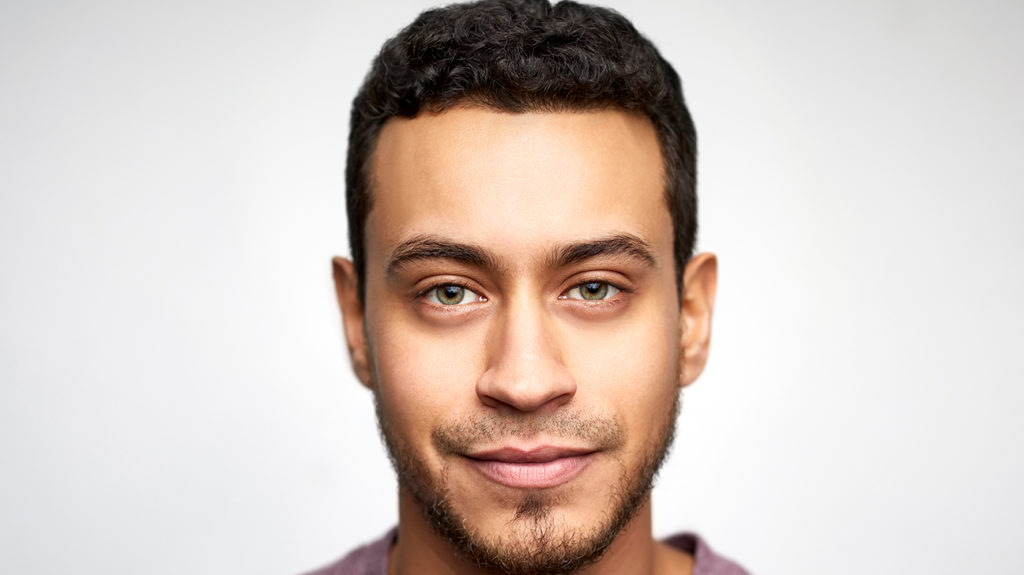

In [ ]:
frame = Image('t.jpg')
from google.colab.patches import cv2_imshow

!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png

import cv2
img = cv2.imread('t.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# New section

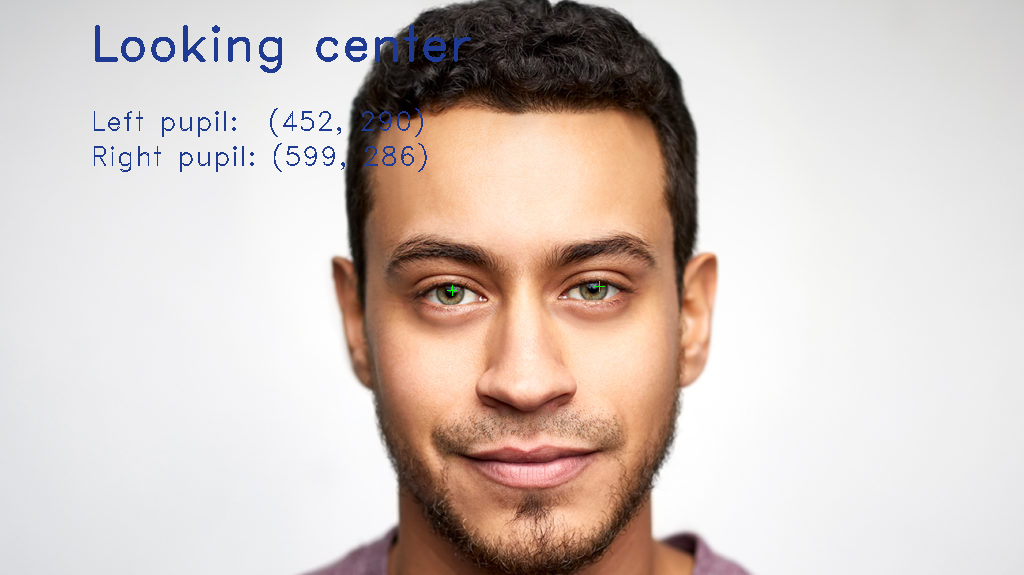

In [ ]:
gaze = GazeTracking()
gaze.refresh(img)
frame = gaze.annotated_frame()
text = ""

if gaze.is_blinking():
        text = "Blinking"
elif gaze.is_right():
        text = "Looking right"
elif gaze.is_left():
        text = "Looking left"
elif gaze.is_center():
        text = "Looking center"

cv2.putText(frame, text, (90, 60), cv2.FONT_HERSHEY_DUPLEX, 1.6, (147, 58, 31), 2)

left_pupil = gaze.pupil_left_coords()
right_pupil = gaze.pupil_right_coords()
cv2.putText(frame, "Left pupil:  " + str(left_pupil), (90, 130), cv2.FONT_HERSHEY_DUPLEX, 0.9, (147, 58, 31), 1)
cv2.putText(frame, "Right pupil: " + str(right_pupil), (90, 165), cv2.FONT_HERSHEY_DUPLEX, 0.9, (147, 58, 31), 1)

cv2_imshow(frame)



Please execute the below code in offline Python compiler !
(google colab doesn't provide "dlib" and "opencv" libraries).

In [ ]:
import cv2
import numpy as np
import dlib
from math import hypot

In [ ]:
# we used the detector to detect the frontal face
detector = dlib.get_frontal_face_detector()

# it will dectect the facial landwark points 
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

font = cv2.FONT_HERSHEY_PLAIN

#Keyboard setting 
keyboard = np.zeros((600,1000,3),np.uint8)
#dictionary containing the letters, each one associated with an index.
keys_set_1 = {0: "Q", 1: "W", 2: "E", 3: "R", 4: "T",
              5: "A", 6: "S", 7: "D", 8: "F", 9: "G",
              10: "Z", 11: "X", 12: "C", 13: "V", 14: "B"}

In [ ]:
def letter(letter_index,text,letter_light):
    
    # Keys 
    #Each key is simply a rectangle containing some text. So we define the sizes and we draw the rectangle.
    if letter_index == 0:
        x = 0
        y = 0
    elif letter_index ==1:
        x =200
        y =0
    elif letter_index ==2:
        x = 400
        y = 0
      
    elif letter_index ==3:
        x= 600
        y = 0
    elif letter_index ==4:
        x = 800
        y = 0
        
    elif letter_index == 5:
        x = 0
        y = 200
    elif letter_index ==6:
        x =200
        y =200
    elif letter_index ==7:
        x = 400
        y = 200
      
    elif letter_index ==8:
        x= 600
        y = 200
    elif letter_index ==9:
        x = 800
        y = 200   
        
    elif letter_index == 10:
        x = 0
        y = 400
    elif letter_index ==11:
        x =200
        y =400
    elif letter_index ==12:
        x = 400
        y = 400
      
    elif letter_index ==13:
        x= 600
        y = 400
    elif letter_index ==14:
        x = 800
        y = 400    
    width = 200
    height = 200
    th = 3 # thickness
    
    if letter_light == True:
        cv2.rectangle(keyboard, (x + th, y + th), (x + width - th, y + height - th), (255, 255, 255), -1)

    else:   
        cv2.rectangle(keyboard, (x + th, y + th), (x + width - th, y + height - th), (255, 0, 0), th)
    
    
    #Inside the rectangle now we put the letter. So we define the sizes and style of the text and we center it.
    #Text settings
    font_letter = cv2.FONT_HERSHEY_PLAIN
    font_scale = 10
    font_th = 4
    text_size = cv2.getTextSize(text, font_letter, font_scale, font_th)[0]
    width_text, height_text = text_size[0], text_size[1]
    text_x = int((width - width_text) / 2) + x
    text_y = int((height + height_text) / 2) + y
    cv2.putText(keyboard, text, (text_x, text_y), font_letter, font_scale, (255, 0, 0), font_th)

In [ ]:

#We create a function that we will need later on to detect the medium point.
#On this function we simply put the coordinates of two points and will return the medium point 
#(the points in the middle between the two points).
def midpoint(p1 ,p2):
    return int((p1.x + p2.x)/2), int((p1.y + p2.y)/2)

In [ ]:
def get_blinking_ratio(eye_points, facial_landmarks):
    
    #to detect the left_side of a left eye
    left_point = (facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y)
    
    #to detect the right_side of the left eye
    right_point = (facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y)
    
    #to detect the mid point for the center of top in left eye
    center_top = midpoint(facial_landmarks.part(eye_points[1]), facial_landmarks.part(eye_points[2]))
    
    #to detect the mid point for the center of the bottom in left eye
    center_bottom = midpoint(facial_landmarks.part(eye_points[5]), facial_landmarks.part(eye_points[4]))
    
    #to calculate horizontal line distance
    hor_line_lenght = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))
    
    #to calculate vertical line distance
    ver_line_lenght = hypot((center_top[0] - center_bottom[0]), (center_top[1] - center_bottom[1]))
    
    #to calculate ratio
    ratio = hor_line_lenght / ver_line_lenght
    
    return ratio

In [ ]:
def get_gaze_ratio(eye_points,facial_landmarks):
    # Gaze detection
        #getting the area from the frame of the left eye only
        left_eye_region = np.array([(facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y),
                            (facial_landmarks.part(eye_points[1]).x, facial_landmarks.part(eye_points[1]).y),
                            (facial_landmarks.part(eye_points[2]).x, facial_landmarks.part(eye_points[2]).y),
                            (facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y),
                            (facial_landmarks.part(eye_points[4]).x, facial_landmarks.part(eye_points[4]).y),
                            (facial_landmarks.part(eye_points[5]).x, facial_landmarks.part(eye_points[5]).y)], np.int32)
        
        #cv2.polylines(frame, [left_eye_region], True, 255, 2)
        height, width, _ = frame.shape
    
        #create the mask to extract xactly the inside of the left eye and exclude all the sorroundings.
        mask = np.zeros((height, width), np.uint8)
        cv2.polylines(mask, [left_eye_region], True, 255, 2)
        cv2.fillPoly(mask, [left_eye_region], 255)
        eye = cv2.bitwise_and(gray,gray,mask = mask)
        
        #We now extract the eye from the face and we put it on his own window.Onlyt we need to keep in mind that wecan only cut
        #out rectangular shapes from the image, so we take all the extremes points of the eyes to get the rectangle
        min_x = np.min(left_eye_region[:, 0])
        max_x = np.max(left_eye_region[:, 0])
        min_y = np.min(left_eye_region[:, 1])
        max_y = np.max(left_eye_region[:, 1])
        gray_eye = eye[min_y: max_y, min_x: max_x]
        
        #threshold to seperate iris and pupil from the white part of the eye.
        _, threshold_eye = cv2.threshold(gray_eye, 70, 255, cv2.THRESH_BINARY)
        
        #dividing the eye into 2 parts .left_side and right_side.
        height, width = threshold_eye.shape
        left_side_threshold = threshold_eye[0: height, 0: int(width / 2)]
        left_side_white = cv2.countNonZero(left_side_threshold)
        right_side_threshold = threshold_eye[0: height, int(width / 2): width]
        right_side_white = cv2.countNonZero(right_side_threshold)
        
        if left_side_white == 0:
            gaze_ratio = 1
            
        elif right_side_white == 0:
            gaze_ratio = 5
            
        else:
            gaze_ratio = left_side_white / right_side_white
        return(gaze_ratio)

In [ ]:
# to open webcab to capture the image
cap = cv2.VideoCapture(0)


#Going to create a white image which is going to be the board where we will put the letters we click from the virtual keyboard.
board = np.zeros((500,500,), np.uint8)
board[:]=255

#Counters
#To count the number of the frames
frames = 0

#The blinking_frames variable will keep track of the frames in a row in which the eyes are blinking.
blinking_frames = 0

letter_index = 0

#Text is going to contain all the letter that we will press when we blink our eyes.
text = ""

while True:
    _,frame = cap.read()
    frames = frames+1
    frame = cv2.resize(frame,None,fx= 0.5, fy = 0.5)
    keyboard[:] = (0,0,0)
    
    #showing direction
    new_frame = np.zeros((500,500,3),np.uint8)
    
    #change the color of the frame captured by webcam to grey
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    active_letter = keys_set_1[letter_index]
    
    # to detect faces from grey color frame
    faces = detector(gray)
    for face in faces:
        
        #to detect the landmarks of a face
        landmarks = predictor(gray, face)
        
        left_eye_ratio = get_blinking_ratio([36, 37, 38, 39, 40, 41], landmarks)
        right_eye_ratio = get_blinking_ratio([42, 43, 44, 45, 46, 47], landmarks)
        blinking_ratio = (left_eye_ratio + right_eye_ratio) / 2

    
        if blinking_ratio>5.7:
            cv2.putText(frame, "BLINKING", (50, 150), font, 4, (255, 0, 0),thickness = 3)
            blinking_frames = blinking_frames + 1
            frames = frames -1
            
            if blinking_frames == 5:
                text = text+active_letter
        else:
            blinking_frames = 0
    
    #letters
    #Then just after the blinking detection we add +1 to the blinking frames and when the blinking is detected for 5 frames in a
    #row then we add the selected letter to the text.
    if frames == 15:
        letter_index = letter_index + 1
        frames = 0
    if letter_index == 15:
        letter_index = 0
        
    for i in range(15):
        if i == letter_index:
            light = True
        else:
            light = False
        letter(i,keys_set_1[i],light)
    
    #Finally we display the text on the board.
    cv2.putText(board,text,(10,100),font,4 ,0,3)    
        
    cv2.imshow("Frame",frame)
    #cv2.imshow("NEW_Frame",new_frame)
    cv2.imshow("Keyboard",keyboard)
    cv2.imshow("Board",board)
    
    key = cv2.waitKey(1)
    #close the webcam when escape key is pressed
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()